# Prevalence of Personal Attacks

In this notebook, we do some basic investigation into the frequency of personal attacks on Wikipedia. We will attempt to provide some insight into the following questions:

- What fraction of comments are personal attacks?

- What fraction of users have made a personal attack?

- What fraction of users have been attacked on their user page?

- Are there any temporal trends in the frequency of attacks?


We have 2 separate types of data at our disposal. First, we have a random sample of roughly 100k human-labeled comments. Each comment was annotated by 10 separate people as to whether the comment is a personal attack. We take the majority annotation class to get a single label. Second, we have the full history of comments with scores generated by a machine learning model. Due to the construction of the model, these scores can be interpreted as the probability that the majority of annotators would label the comment as an attack.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from load_utils import *
from analysis_utils import compare_groups

In [2]:
d = load_diffs()
df_events, df_blocked_user_text = load_block_events_and_users()

In [3]:
er_t = 0.425
d['2015']['pred_attack'] = (d['2015']['pred_attack_score_uncalibrated'] > er_t).astype(int)
d['sample']['pred_attack'] = (d['sample']['pred_attack_score_uncalibrated'] > er_t).astype(int)

### Q: What fraction of comments are personal attacks?

In [4]:
# calibration based

In [5]:
100 * d['2015']['pred_attack_score_calibrated'].mean()

0.7219126397993685

In [6]:
100 * d['2015'].groupby('ns')['pred_attack_score_calibrated'].mean()

ns
article    0.420763
user       1.042068
Name: pred_attack_score_calibrated, dtype: float64

In [7]:
### threshold based

In [8]:
100 * d['2015']['pred_attack'].mean()

0.7142112371277175

In [9]:
100 * d['2015'].groupby('ns')['pred_attack'].mean()

ns
article    0.397500
user       1.050909
Name: pred_attack, dtype: float64

### Q: What fraction of users have made/received  at least k personal attacks?

#### 1.  threshold based

In [10]:
ks = [1,3,5]
attacker_ys = []
receiver_ys = []

for k in ks:
    attacker_ys.append(d['2015'].groupby('user_text')['pred_attack'].sum().apply(lambda x: x >= k).mean() * 100)
    
for k in ks:
    receiver_ys.append(d['2015'].query("ns=='user'and user_text != page_title").groupby('page_title')['pred_attack'].sum().apply(lambda x: x >= k).mean() * 100)

In [11]:
df_sns = pd.DataFrame()
df_sns['k'] = ks
df_sns['attackers'] = attacker_ys
df_sns['victims'] = receiver_ys

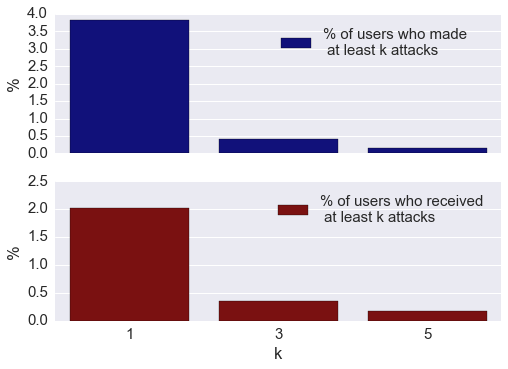

In [12]:
plt.figure()

sns.set(font_scale=1.5)
f, (ax1, ax2) = plt.subplots(2, sharex=True)
sns.barplot("k", y="attackers", data=df_sns, ax=ax1, color =  'darkblue' , label = "% of users who made     \n at least k attacks")
sns.barplot("k", y="victims", data=df_sns, ax=ax2,  color =  'darkred', label =    "% of users who received \n at least k attacks")
ax1.set( xlabel = '' , ylabel = '%')
ax2.set( ylabel = '%')

ax1.legend()
ax2.legend()
plt.savefig('../../paper/figs/attacker_and_victim_prevalence.png')

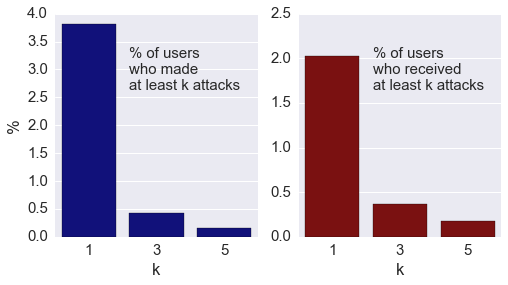

In [13]:
plt.figure()

sns.set(font_scale=1.5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
sns.barplot("k", y="attackers", data=df_sns, ax=ax1, color =  'darkblue' )
sns.barplot("k", y="victims", data=df_sns, ax=ax2,  color =  'darkred')
ax1.set( ylabel = '%')
ax2.set( ylabel = '')
plt.text(- 3.0, 1.65,'% of users \nwho made \nat least k attacks',fontsize = 15)
plt.text(0.6, 1.65,'% of users \nwho received \nat least k attacks',fontsize = 15)

ax2.legend()
plt.savefig('../../paper/figs/attacker_and_victim_prevalence.png')

#### 2.  calibration based
Take unsampled data. For each comment, let it be an attack with probability equal to the model prediction. Count the number of users that have made at least 1 attack. Repeat.

In [14]:
def simulate_num_attacks_within_group(df, group_col = 'user_text'):
    return df.assign( uniform = np.random.rand(df.shape[0], 1))\
        .assign(is_attack = lambda x: (x.pred_attack_score_calibrated >= x.uniform).astype(int))\
        .groupby(group_col)['is_attack']\
        .sum()

In [15]:
def get_within_group_metric_interval(df, group_col = 'user_text', metric = lambda x: (x>=1).astype(int).mean() * 100, iters = 2):
    results = []
    for i in range(iters):
        result = simulate_num_attacks_within_group(df, group_col = group_col)
        result = metric(result)
        results.append(result)
    return np.percentile(results, [2.5, 97.5]) 
    

In [16]:
def get_intervals(df, group_col = 'user_text', iters = 10):

    ks = range(1,6)
    y =[]
    lower = []
    upper = []
    intervals = []

    for k in ks:
        metric = lambda x: (x>=k).astype(int).mean() * 100
        interval = get_within_group_metric_interval(d['2015'], group_col = group_col, iters = iters, metric=metric)
        intervals.append(interval)
        y.append(interval.mean())
        lower.append(interval.mean() - interval[0])
        upper.append(interval[1] - interval.mean())
        
    return pd.DataFrame({'k': ks, 'y': y, 'interval': intervals, 'lower': lower, 'upper': upper})

In [17]:
get_intervals(d['2015'])

,interval,k,lower,upper,y
0,"[3.85717147436, 3.90753777473]",1,0.025183,0.025183,3.882355
1,"[0.855170470555, 0.885989010989]",2,0.015409,0.015409,0.870580
2,"[0.4048015286, 0.41891201747]",3,0.007055,0.007055,0.411857
3,"[0.234760231755, 0.246933555227]",4,0.006087,0.006087,0.240847
4,"[0.153465324739, 0.165781734291]",5,0.006158,0.006158,0.159624


In [18]:
# ignore anon users
get_intervals(d['2015'].query('not author_anon and not recipient_anon'))

,interval,k,lower,upper,y
0,"[3.85692932868, 3.90649214567]",1,0.024781,0.024781,3.881711
1,"[0.857867092843, 0.899615208509]",2,0.020874,0.020874,0.878741
2,"[0.403095502254, 0.41863685193]",3,0.007771,0.007771,0.410866
3,"[0.236576324317, 0.254219938715]",4,0.008822,0.008822,0.245398
4,"[0.155666649056, 0.165880793886]",5,0.005107,0.005107,0.160774


In [19]:
get_intervals(d['2015'].query("ns=='user'"), group_col = 'page_title')

,interval,k,lower,upper,y
0,"[1.90727792059, 1.93320765496]",1,0.012965,0.012965,1.920243
1,"[0.437063696087, 0.455115681234]",2,0.009026,0.009026,0.446090
2,"[0.217766352471, 0.223427592117]",3,0.002831,0.002831,0.220597
3,"[0.131648100543, 0.138423307626]",4,0.003388,0.003388,0.135036
4,"[0.0878263353328, 0.0956640959726]",5,0.003919,0.003919,0.091745


In [20]:
# ignore anon users
get_intervals(d['2015'].query("not author_anon and not recipient_anon and ns=='user'"), group_col = 'page_title')

,interval,k,lower,upper,y
0,"[1.90000571265, 1.9395944016]",1,0.019794,0.019794,1.919800
1,"[0.434264495858, 0.449848614682]",2,0.007792,0.007792,0.442057
2,"[0.214721508141, 0.225524135961]",3,0.005401,0.005401,0.220123
3,"[0.130025706941, 0.140451299629]",4,0.005213,0.005213,0.135239
4,"[0.0875007140817, 0.095332762068]",5,0.003916,0.003916,0.091417


### Q: Has the proportion of attacks changed year over year?

In [21]:
df_span = d['sample'].query('year > 2003 & year < 2016')

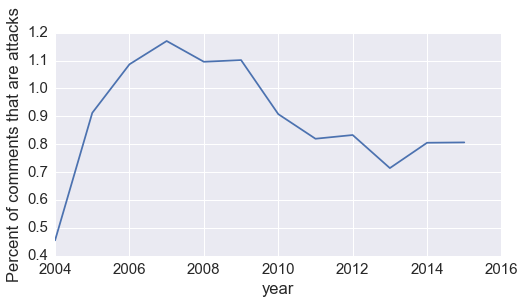

In [22]:
plt.figure(figsize=(8,4))
sns.set(font_scale=1.5)
x = 'year'
s = df_span.groupby(x)['pred_attack'].mean() * 100
plt.plot(s.index, s.values)
plt.xlabel(x)
plt.ylabel('Percent of comments that are attacks')
plt.savefig('../../paper/figs/prevalence_by_year.png')

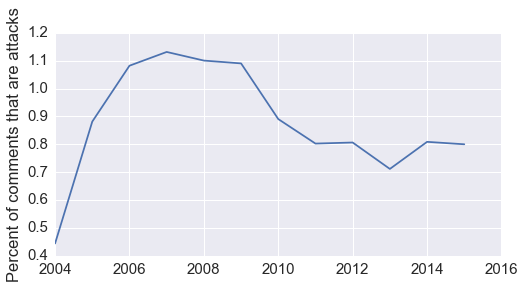

In [23]:
plt.figure(figsize=(8,4))
sns.set(font_scale=1.5)
x = 'year'
s = df_span.groupby(x)['pred_attack_score_calibrated'].mean() * 100
plt.plot(s.index, s.values)
plt.xlabel('')
plt.ylabel('Percent of comments that are attacks')
#plt.savefig('../../paper/figs/prevalence_by_year.png')


There is a strong yearly pattern. The fraction of attacks peaked in 2008, which is when participation peaked as well.